In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, random, keras, pickle, gc
from sklearn.model_selection import train_test_split

import tensorflow as tf
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from face_verification.facenet import basenet
from face_verification.facenet import triplet_net
from face_verification.facenet import triplet_loss
from face_verification.facenet import train_triplet_generator
from face_verification.facenet import test_triplet_generator

%matplotlib inline

Using TensorFlow backend.


# Load Image Dictionary

In [ ]:
# pre-process the train and test dataframe
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [ ]:
import os
image = pd.DataFrame(columns = ['name', 'path'])
for i in os.listdir('../lfw'): 
    for fig in os.listdir('../lfw/{}'.format(i)):
        if 'jpg' in fig:
            image = image.append({'name': i, 'path': '../lfw/{}/{}'.format(i, fig)}, ignore_index = True)
image

,name,path
0,Lina_Krasnoroutskaya,../lfw/Lina_Krasnoroutskaya/Lina_Krasnoroutska...
1,Lina_Krasnoroutskaya,../lfw/Lina_Krasnoroutskaya/Lina_Krasnoroutska...
2,Zahir_Shah,../lfw/Zahir_Shah/Zahir_Shah_0001.jpg
3,Elizabeth_Dole,../lfw/Elizabeth_Dole/Elizabeth_Dole_0003.jpg
4,Elizabeth_Dole,../lfw/Elizabeth_Dole/Elizabeth_Dole_0001.jpg
...,...,...
13228,Karol_Kucera,../lfw/Karol_Kucera/Karol_Kucera_0001.jpg
13229,Julio_Cesar_Chavez,../lfw/Julio_Cesar_Chavez/Julio_Cesar_Chavez_0...
13230,Adelina_Avila,../lfw/Adelina_Avila/Adelina_Avila_0001.jpg
13231,Oscar_Elias_Biscet,../lfw/Oscar_Elias_Biscet/Oscar_Elias_Biscet_0...


In [ ]:
image_train, image_test, _, _ = train_test_split(image, np.ones(image.shape[0]), test_size=0.1, random_state=42)

train_df = image_train.groupby('name').apply(path_to_list).reset_index()
test_df = image_test.groupby('name').apply(path_to_list).reset_index()
train_df, test_df

(                 name  count  \
 0             AJ_Cook      1   
 1            AJ_Lamas      1   
 2       Aaron_Eckhart      1   
 3         Aaron_Guiel      1   
 4     Aaron_Patterson      1   
 ...               ...    ...   
 5332   Zoran_Djindjic      4   
 5333   Zorica_Radovic      1   
 5334   Zulfiqar_Ahmed      1   
 5335     Zumrati_Juma      1   
 5336  Zurab_Tsereteli      1   
 
                                                   paths  
 0                     [../lfw/AJ_Cook/AJ_Cook_0001.jpg]  
 1                   [../lfw/AJ_Lamas/AJ_Lamas_0001.jpg]  
 2         [../lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg]  
 3             [../lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg]  
 4     [../lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg]  
 ...                                                 ...  
 5332  [../lfw/Zoran_Djindjic/Zoran_Djindjic_0004.jpg...  
 5333    [../lfw/Zorica_Radovic/Zorica_Radovic_0001.jpg]  
 5334    [../lfw/Zulfiqar_Ahmed/Zulfiqar_Ahmed_0001.jpg]  
 5335       

# Define Triplet Network

In [ ]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(seed)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# K.set_session(sess)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.ConfigProto(log_device_placement=True))

In [ ]:
# create the base-cnn model
base_model = basenet(output_shape=128)

# # visualization
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.png')
# plot_model(base_model, show_shapes=True, to_file='./results/base-model.pdf')

# base-model summary
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 102, 102, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_23[0][0]          
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
# create the triplet-network model
triplet_model = triplet_net(base_model=base_model, input_shape=(96, 96, 3))

# # visualization
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.png')
# plot_model(triplet_model, show_shapes=True, to_file='./results/triplet-model.pdf')

# base-model summary
triplet_model.summary()

Model: "triplet_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128)          3743280     anchor_input[0][0]               
                                                                 positive_input[0][0]   

# Triplet Network Training

In [ ]:
# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 900:
        lr *= 1e-1
    elif epoch > 800:
        lr *= 2e-1
    elif epoch > 700:
        lr *= 3e-1
    elif epoch > 600:
        lr *= 4e-1
    elif epoch > 500:
        lr *= 5e-1
    elif epoch > 400:
        lr *= 6e-1
    elif epoch > 300:
        lr *= 7e-1
    elif epoch > 200:
        lr *= 8e-1
    elif epoch > 100:
        lr *= 9e-1
        
    return lr

In [ ]:
# define optimizer
opt = tf.keras.optimizers.Adam(lr=lr_schedule(0))

# create checkpoint folder
path = './models/margin-01-' + time.strftime('%Y%m%d-%H%M')
if not os.path.exists(path):
    os.mkdir(path)
print('Checkpoing Folder:\t', path)    

# create call backs
checkpoint = ModelCheckpoint(filepath=path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=10)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss(0.1))

# define training and test dataset image generator
train_generator = train_triplet_generator(train_df, batch_size=128)
test_generator = test_triplet_generator(test_df, batch_size=100, loops=10, seed=42)

Checkpoing Folder:	 ./models/margin-01-20220615-2220


In [ ]:
# fit the model
history = triplet_model.fit_generator(train_generator, steps_per_epoch=67, epochs=50, 
                                      validation_data=test_generator, validation_steps=50, 
                                      verbose=2)

base_model.save(path + '/facenet-model_50.h5')
pickle.dump(history.history, open(path + '/facenet-history_50.p', 'wb'))
_ = gc.collect()

Epoch 1/50
67/67 - 71s - loss: 2.0326 - val_loss: 1.3533
Epoch 2/50
67/67 - 69s - loss: 1.8205 - val_loss: 1.6513
Epoch 3/50
67/67 - 70s - loss: 1.7296 - val_loss: 1.2698
Epoch 4/50
67/67 - 70s - loss: 1.5758 - val_loss: 0.7893
Epoch 5/50
67/67 - 70s - loss: 1.5223 - val_loss: 0.7362
Epoch 6/50
67/67 - 69s - loss: 1.4092 - val_loss: 1.0176
Epoch 7/50
67/67 - 70s - loss: 1.2484 - val_loss: 0.7621
Epoch 8/50
67/67 - 69s - loss: 1.3774 - val_loss: 0.7710
Epoch 9/50
67/67 - 70s - loss: 1.1930 - val_loss: 0.8140
Epoch 10/50
67/67 - 67s - loss: 1.1799 - val_loss: 0.7011
Epoch 11/50
67/67 - 68s - loss: 1.1425 - val_loss: 0.6486
Epoch 12/50
67/67 - 67s - loss: 1.2082 - val_loss: 0.7845
Epoch 13/50
67/67 - 67s - loss: 1.0645 - val_loss: 0.8864
Epoch 14/50
67/67 - 68s - loss: 1.0166 - val_loss: 0.8494
Epoch 15/50
67/67 - 68s - loss: 1.0987 - val_loss: 0.7092
Epoch 16/50
67/67 - 67s - loss: 1.0911 - val_loss: 0.7349
Epoch 17/50
67/67 - 67s - loss: 1.0730 - val_loss: 0.7024
Epoch 18/50
67/67 - 69s

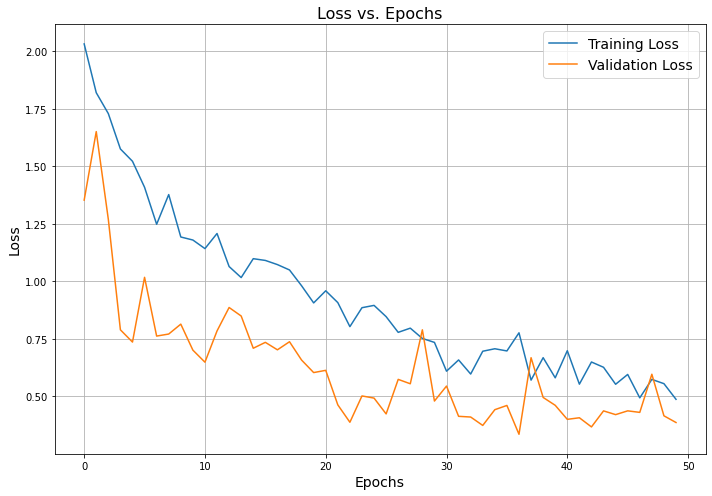

In [ ]:
# Visualize the training process  
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.show()

# Prediction

In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from face_verification.api import *
from face_verification.utils import *

%matplotlib inline

In [ ]:
# test image path and name list
path_list = ['./images/test/Aaron_Peirsol_01.jpg', 
             './images/test/Aaron_Peirsol_02.jpg', 
             './images/test/Aaron_Sorkin_01.jpg', 
             './images/test/Aaron_Sorkin_02.jpg', 
             './images/test/Annette_Bening_01.jpg', 
             './images/test/Annette_Bening_02.jpg']

name_list = ['Aaron Peirsol 1', 'Aaron Peirsol 2', 'Aaron Sorkin 1', 
             'Aaron Sorkin 2', 'Annette Bening 1', 'Annette Bening 2']

In [ ]:
# define path to pre-trained model and haar xml
model_path = './models/facenet-margin-01-final.h5'
xml_path = './face_verification/xmls/haarcascade_frontalface_default.xml'

# intialize face verification model
face_model = face_verify(path=model_path, xml=xml_path)

In [ ]:
print('| {0:^20s} | {1:^20s} | {2:^10s} |'.format('Name', 'Name', 'Distance'))
print('-' * 60)
for i in range(len(path_list)):
    for j in range(len(path_list)):
        if i == j:
            continue
        
        # get paths to image
        path1 = path_list[i]
        path2 = path_list[j]
        
        # get the distance of image 1 and image 2
        img1, img2, distance = face_model.get_distance(path1, path2)
        name1, name2 = name_list[i], name_list[j]
        print('| {0:^20s} | {1:^20s} | {2:^10.6f} |'.format(name1, name2, distance))
    print()

|         Name         |         Name         |  Distance  |
------------------------------------------------------------
|   Aaron Peirsol 1    |   Aaron Peirsol 2    |  0.080878  |
|   Aaron Peirsol 1    |    Aaron Sorkin 1    |  0.239907  |
|   Aaron Peirsol 1    |    Aaron Sorkin 2    |  0.171671  |
|   Aaron Peirsol 1    |   Annette Bening 1   |  0.151884  |
|   Aaron Peirsol 1    |   Annette Bening 2   |  0.150457  |

|   Aaron Peirsol 2    |   Aaron Peirsol 1    |  0.080878  |
|   Aaron Peirsol 2    |    Aaron Sorkin 1    |  0.251050  |
|   Aaron Peirsol 2    |    Aaron Sorkin 2    |  0.174558  |
|   Aaron Peirsol 2    |   Annette Bening 1   |  0.152690  |
|   Aaron Peirsol 2    |   Annette Bening 2   |  0.130374  |

|    Aaron Sorkin 1    |   Aaron Peirsol 1    |  0.239907  |
|    Aaron Sorkin 1    |   Aaron Peirsol 2    |  0.251050  |
|    Aaron Sorkin 1    |    Aaron Sorkin 2    |  0.149091  |
|    Aaron Sorkin 1    |   Annette Bening 1   |  0.317565  |
|    Aaron Sorkin 1   

# Reference
1. Link: https://github.com/JifuZhao/face-verification